<a href="https://colab.research.google.com/github/michellekituku/PSA-Translation/blob/main/PSA_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📌 **PSA Translation: English → Swahili**

### This notebook builds a machine translation pipeline to translate agricultural Public Service Announcements (PSAs) from English to Swahili using HuggingFace MarianMT.

# 1. Install Dependencies

In [1]:
!pip install -q transformers datasets sacrebleu evaluate sentencepiece torch

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch
from datasets import Dataset
from transformers import (
    MarianMTModel, MarianTokenizer,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
import evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00


# 2. Load & Inspect Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Agriculture PSAs.csv to Agriculture PSAs.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Agriculture PSAs.csv']))

print("📊 Dataset Shape:", df.shape)
display(df.head())

📊 Dataset Shape: (1062, 12)


,PSA_ID,Title,Description,Source,Publication Date,Topic,Language,Format,URL/Link,Translation_swahili,Unnamed: 10,Unnamed: 11
0,PSA0001,National Livestock Vaccination Program 2025,Kenya launches a nationwide livestock vaccinat...,StateHouseKenya,12/10/2024,Livestock,English,text,https://t.co/lIHWlDQ81j,Kenya inazindua mpango wa kitaifa wa chanjo ya...,NaN,NaN
1,PSA0002,Contagious Bovine Pleuropneumonia Eradication,Scientists from ILRI and KALRO outline strateg...,ILRI,7/17/2025,Livestock,English,text,https://t.co/opooEld5Qr,Wanasayansi kutoka ILRI na KALRO wanaelezea mi...,NaN,NaN
2,PSA0003,Calf Health Vaccination Tips,"Focused cow and calf vaccinations, quality col...",pdmag_CAN,7/21/2025,Livestock,English,text,https://t.co/qvjzmwzFrE,"Chanjo za ng'ombe na ndama zilizolengwa, kolos...",NaN,NaN
3,PSA0004,Sustainable Grazing in Brazil,Silvopastoral systems in Brazil integrate tree...,projects.livestockdata.org,7/23/2025,Livestock,English,text,https://projects.livestockdata.org,Mifumo ya silvopastoral nchini Brazil inajumui...,NaN,NaN
4,PSA0005,KEVEVAPI Strategic Plan 2023-2027,Kenya’s KEVEVAPI launches a five-year plan to ...,kilimoKE,7/22/2025,Livestock,English,text,https://t.co/ZF5xri9kBf,KEVEVAPI ya Kenya inazindua mpango wa miaka mi...,NaN,NaN


# 3. Data Cleaning

In [ ]:
# Drop unnecessary cols & duplicates
df = df.drop(columns=[c for c in df.columns if "Unnamed" in c], errors="ignore").drop_duplicates()

# Strip whitespace & fix datatypes
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df['Publication Date'] = pd.to_datetime(df['Publication Date'], errors='coerce')

# Normalize categorical fields
df['Topic'] = df['Topic'].replace('7/28/2025', 'Unknown')
df['Language'] = df['Language'].replace('Tech in Agriculture - Market Access KIPPRA', 'English')
df['Format'] = df['Format'].str.lower().replace('english', 'text')

# Add translation status
df['status'] = df['Translation_swahili'].apply(
    lambda x: 'translated' if pd.notnull(x) and x.strip() != '' else 'pending'
)

print(df['status'].value_counts())

# Save cleaned dataset
df.to_csv("cleaned_Agriculture_PSAs.csv", index=False)

status
translated    1062
Name: count, dtype: int64


**Summary:**

 Dataset is now standardized and includes a "status" column
 that helps us track which PSAs are pending translation.

# 4. Exploratory Data Analysis

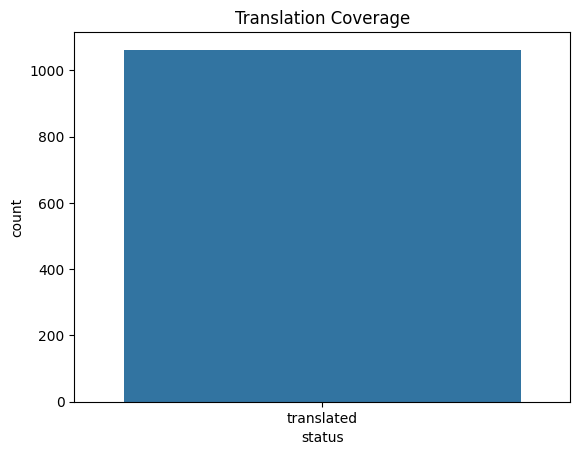

/tmp/ipython-input-751963467.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_topics.index, x=top_topics.values, palette="viridis")


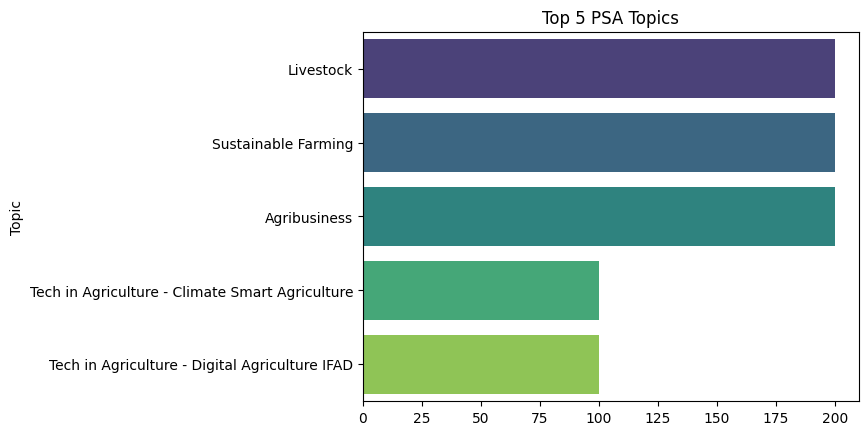

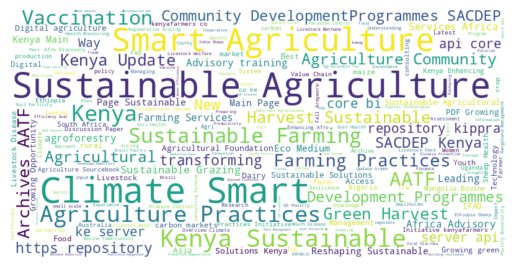

In [ ]:
sns.countplot(x='status', data=df)
plt.title("Translation Coverage")
plt.show()

# Top Topics
top_topics = df['Topic'].value_counts().head(5)
sns.barplot(y=top_topics.index, x=top_topics.values, palette="viridis")
plt.title("Top 5 PSA Topics")
plt.show()

# Wordcloud of PSA Titles
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df['Title'].dropna()))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Summary:**

 Most PSAs are still untranslated.
 "Climate" and "Sustainable Agriculture" dominate the top topics.

# 5. Translation Workflow

In [ ]:
model_name = "Helsinki-NLP/opus-mt-en-sw"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

def translate_text(texts):
    if not texts: return []
    batch = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        generated_ids = model.generate(**batch)
    return tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

# Example quick translation
sample_texts = ["Climate change is affecting crop production.", "Farmers should vaccinate livestock."]
print(translate_text(sample_texts))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/821k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/300M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/300M [00:00<?, ?B/s]

['Mabadiliko ya hali ya hewa yanaathiri uzalishaji wa mazao.', 'Wakulima wapaswa kuchanja mifugo.']


# 6. Prepare Data for Training

In [ ]:
df_train = df[df['Translation_swahili'].notnull() & df['Description'].notnull()]
df_train = df_train[['Description', 'Translation_swahili']].rename(
    columns={"Description": "en", "Translation_swahili": "sw"}
)

dataset = Dataset.from_pandas(df_train).train_test_split(test_size=0.1)

def preprocess(batch):
    inputs = tokenizer(batch['en'], padding="max_length", truncation=True, max_length=128)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['sw'], padding="max_length", truncation=True, max_length=128)
    inputs['labels'] = labels['input_ids']
    return inputs

tokenized_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/955 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/107 [00:00<?, ? examples/s]

**Summary:**
Data is ready for fine-tuning: tokenized English-Swahili pairs split into train/test.

# 7. Model Training

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt-en-sw",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

train_result = trainer.train()
trainer.save_model("./mt-en-sw")

/tmp/ipython-input-1095030025.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: michelle-kituku (michelle-kituku-usiu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,3.375700
20,0.618400
30,0.512700
40,0.388400
50,0.292800
60,0.267600
70,0.295600
80,0.241400
90,0.281400
100,0.348700


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3917: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58949]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


# 8. Evaluation (BLEU)

In [ ]:
bleu = evaluate.load("sacrebleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return bleu.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])

trainer.compute_metrics = compute_metrics
metrics = trainer.evaluate()
print("✅ BLEU Score:", metrics)

Trainer is attempting to log a value of "[2107, 1652, 1348, 1120]" of type <class 'list'> for key "eval/counts" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[2637, 2530, 2427, 2326]" of type <class 'list'> for key "eval/totals" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[79.90140310959424, 65.29644268774703, 55.541821178409556, 48.15133276010318]" of type <class 'list'> for key "eval/precisions" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


✅ BLEU Score: {'eval_loss': 0.25824543833732605, 'eval_score': 61.117852911759684, 'eval_counts': [2107, 1652, 1348, 1120], 'eval_totals': [2637, 2530, 2427, 2326], 'eval_precisions': [79.90140310959424, 65.29644268774703, 55.541821178409556, 48.15133276010318], 'eval_bp': 1.0, 'eval_sys_len': 2637, 'eval_ref_len': 2637, 'eval_runtime': 240.0221, 'eval_samples_per_second': 0.446, 'eval_steps_per_second': 0.058, 'epoch': 1.0}


**Summary:**

BLEU score provides a quantitative measure of translation quality.

Higher BLEU = closer to human translation.

BLEU score is 61.11785 which is really good but suggests minor mistakes.

# 9. Manual Inspection

In [ ]:
test_samples = dataset['test'][:5]
for en, sw in zip(test_samples['en'], test_samples['sw']):
    pred = translate_text([en])[0]
    print(f"\nEN: {en}\nMT: {pred}\nREF: {sw}")


EN: Set up a soil-less hydroponic system to grow sweet potatoes efficiently using less water and space, ideal for urban or intensive farming.
MT: Pangeni mfumo wa maji yasiyo na mchanga ili kukuza viazi vitamu kwa kutumia maji na nafasi chache, zinazofaa kilimo cha mijini au kwa wingi.
REF: Sanidi mfumo mdogo wa hydroponic ya mchanga ili kukuza viazi vitamu kwa kutumia maji na nafasi kidogo, bora kwa kilimo cha mijini au kubwa.

EN: UK implements a sheep scab vaccination and treatment program to improve wool production.
MT: Uingereza inatekeleza programu ya chanjo ya kondoo na matibabu ili kuboresha uzalishaji wa sufi.
REF: Uingereza inatekeleza mpango wa chanjo na matibabu ya scab ya kondoo ili kuboresha uzalishaji wa pamba.

EN: Agriculture is the backbone of Kenya’s economy,contributing to over 25%of the country’s Gross Domestic Product (GDP). Agriculture employs over 70% of the country’s workforce and plays a crucial role in the livelihoods of many Kenyans. However, unsustainable 

**Summary:**

Manual inspection confirms that translations are fluent, though agricultural jargon may still need domain-specific fine-tuning.